# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Traffic Sign Recognition Classifier

### Overview
This project's goal is to create traffic signs classifier using deep learning techniques and 'German traffic signs' dataset as a learning data.
The code below is a process of creating such a classifier with explanations and visualizations for each step. These steps are:
- Step 0: Import all the required dependencies
- Step 1: Define a function for loading data
- Step 2: Provide tools for displaying information about input dataset
- Step 3. Process initial data and build a model for learning
- Step 4. Train and validate the model
- Step 5: Test a Model on New Images
- Step 6. Visualize the result of prediction

Write up with all the explanations could be found in: ./writeup.pdf

---
## Step 0: Import all the required dependencies

In [78]:
import functools
from textwrap import wrap
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cv2 as cv
from sklearn.utils import shuffle

%matplotlib inline

## Step 1: Define a function for loading data 

In [41]:
def load_data():
    loaded_data = {}

    training_file = './data/train.p'
    validation_file = './data/valid.p'
    testing_file = './data/test.p'
    labels_file = './signnames.csv'

    with open(training_file, mode='rb') as file:
        train = pickle.load(file)
    with open(validation_file, mode='rb') as file:
        valid = pickle.load(file)
    with open(testing_file, mode='rb') as file:
        test = pickle.load(file)

    loaded_data['x_train'] = train['features']
    loaded_data['y_train'] = train['labels']
    loaded_data['x_valid'] = valid['features']
    loaded_data['y_valid'] = valid['labels']
    loaded_data['x_test'] = test['features']
    loaded_data['y_test'] = test['labels']
    loaded_data['labels'] = np.array(
        pd.read_csv(labels_file, sep=',').values.tolist()
    )
    loaded_data['labels_number'] = loaded_data['labels'].shape[0]

    return loaded_data


## Step 2: Provide tools for displaying information about input dataset

### Assert the equality of images sizes across dataset and print basic info

In [42]:
def show_data_info(data):
    assert(
        data['x_train'].shape[1:] == data['x_valid'].shape[1:] and
        data['x_train'].shape[1:] == data['x_test'].shape[1:]
    )
    print('Total number of training images: {}'.format(data['x_train'].shape[0]))
    print('Total number of validation images: {}'.format(data['x_valid'].shape[0]))
    print('Total number of test images: {}'.format(data['x_test'].shape[0]))
    print('Total number of classes: {}'.format(data['labels_number']))
    print('Image size is {} across dataset'.format(data['x_train'].shape[1:]))

### Display initial distribution of signs images across dataset and display some images from available subsets (train, valid, test)

In [43]:
def show_signs_distribution(data):
    plt.subplots(figsize=(12, 15))
    plt.title('Signs distribution across dataset')
    plt.hist(
        [
            data['y_train'],
            data['y_test'],
            data['y_valid']
        ],
        bins=data['labels_number'],
        color=('#1eb53a', '#f77f00', '#b80c09'),
        orientation='horizontal',
        rwidth=0.7,
        label=('Train', 'Test', 'Valid')
    )
    plt.gca().invert_yaxis()
    plt.yticks(np.arange(data['labels_number']), data['labels'][:, 1])
    plt.xlabel('Number of examples')
    plt.legend(loc='lower right')
    plt.show()

def show_signs(data, signs_per_row=5):
    gallery = {'train': [], 'valid': [], 'test':[]}

    signs_info_rows = np.copy(data['labels'])
    np.random.shuffle(signs_info_rows) #pylint: disable=E1101
    signs_info_rows = signs_info_rows[:5]

    for sign_info in signs_info_rows:
        sign_id = int(sign_info[0])
        sign_name = sign_info[1]

        for key, value in gallery.items():
            y_key = 'y_' + key
            x_key = 'x_' + key
            sign_image_indices = np.where(data[y_key] == sign_id)
            sign_image_index = (sign_image_indices[0][0]
                if isinstance(sign_image_indices, tuple)
                else sign_image_indices[0])

            image = data[x_key][sign_image_index]
            gallery_item = [sign_name, image]
            value.append(gallery_item)

    for key, value in gallery.items():
        plt.figure(figsize=(15, 4))
        plt.suptitle('{} dataset'.format(key.capitalize()), size=18)
        for i in range(signs_per_row):
            title, image = value[i]
            plt.subplot(1, signs_per_row, i+1)
            plt.title('\n'.join(wrap(title, 20)))
            plt.imshow(image)

def visualize_data(data):
    show_signs_distribution(data)
    show_signs(data)

## Step 3. Process initial data and build a model for learning

### 1) Provide logic for augmenting initial dataset

For augmenting dataset I've used next techniques of image processing:
- image rotation combined with scaling. Angle is chosen randomly within predefined range. Scaling is used in order to avoid 'blind areas' of black pixels when we perform rotation. Image rotations was chosen because it is allows us to avoid network's overlearning on sign orientation criteria.
- modifying the perspective of the image. For each image we randomly shift the corners so that result image skew its perspective. This techinque is used in order to prevent case when network relies on the correct form (circle, triangle and so on) of sign. Images can be skewed because of light refraction, not well-mounted sign, or simply because of position at which an image was taken
- blurring image using GaussianBlur. This method was used because we can not rely on the assumption that image was not blurred because of speed or low camera resolution
- combination of blurring and rotation
- combination of blurring and modifying perspective

Note: combination of rotation and perspective modifications is not used, because both of these techniques leads to image scaling. So combinig them we potentially could face a case when image is "overscaled" and only part of sign is visible within initial frame

In [44]:
def compose(*fns):
    return functools.reduce(lambda f, g: lambda x: f(g(x)), fns, lambda x: x)

def generate_rotated_image(img, angle_delta=15, return_meta=False):
    height, width = img.shape[:2]
    angle = np.random.randint(-angle_delta, angle_delta + 1)
    scale = 1.25
    rotation_matrix = cv.getRotationMatrix2D((height / 2, width / 2), angle, scale)
    result_image = cv.warpAffine(img, rotation_matrix, (height, width))
    return ([result_image, angle, scale] if return_meta else result_image)

def generate_perspective_transformed_image(img, dim_delta_percentage=.25, return_meta=False):
    height, width = img.shape[:2]
    max_width_delta = dim_delta_percentage * width
    max_height_delta = dim_delta_percentage * height

    initial_points = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    out_points = np.copy(initial_points)

    for point in out_points:
        x_coord, y_coord = point
        p = np.random.rand(2)
        modify_x, modify_y = np.where(p<0.4, True, False)
        if modify_x:
            x_delta = np.random.randint(0, max_width_delta)
            point[0] = (x_coord + x_delta) if (x_coord > 0) else (x_coord - x_delta)
        if modify_y:
            y_delta = np.random.randint(0, max_height_delta)
            point[1] = (y_coord + y_delta) if (y_coord > 0) else (y_coord - y_delta)

    transform_matrix = cv.getPerspectiveTransform(initial_points, out_points)
    result_image = cv.warpPerspective(img, transform_matrix, (height, width))
    return ([result_image, out_points] if return_meta else result_image)

def generate_blurred_image(img, return_meta=False):
    height, width = img.shape[:2]
    kernel = (7,7)
    blurred_image = cv.GaussianBlur(img, kernel, 0)
    return [blurred_image, kernel] if return_meta else blurred_image

augmentations = [
    generate_blurred_image,
    generate_rotated_image,
    generate_perspective_transformed_image,
    compose(
        generate_blurred_image,
        generate_perspective_transformed_image
    ),
    compose(
        generate_blurred_image,
        generate_rotated_image
    )
]

### 2) Provide logic for data augmentation

For the initial dataset we perform augmentation "per sign", i.e. the more images available for current sign the less fake images we would create and vice versa. All the generated images as well as labels for them are concatenated with initial dataset

In [45]:
def extend_dataset(initial_x, initial_y, labels, labels_total):
    images_per_sign_max = np.max(np.histogram(initial_y, labels_total)[0])
    out_x = np.copy(initial_x)
    out_y = np.copy(initial_y)
    generated_images = []
    generated_labels = []

    for i in range(labels_total):
        sign_id = int(labels[i][0])
        indices_of_sign = np.where(initial_y == sign_id)

        if isinstance(indices_of_sign, tuple):
            indices_to_concat = []
            for indices_arr in indices_of_sign:
                indices_to_concat.append(indices_arr)
            indices_of_sign = np.concatenate(indices_to_concat)

        images_per_sign = indices_of_sign.shape[0]
        divident = 80000
        total_generated_images = int(divident / images_per_sign)
        input_indices = indices_of_sign[:total_generated_images]

        for counter in range(total_generated_images):
            index = np.random.choice(input_indices)
            initial_image = initial_x[index]
            augmentation = np.random.choice(augmentations)
            result_image = augmentation(initial_image)
            generated_images.append(result_image)
            generated_labels.append(sign_id)

    out_x = np.concatenate((out_x, generated_images))
    out_y = np.concatenate((out_y, generated_labels))

    return [out_x, out_y]

### 3) Provide logic for data preprocessing

Preprocess data in order to convert input images to the format required for neural network. Two techiques are used:
- grayscaling is used in order to minimize the noise caused by different light conditions, ISO settings of camera and so on
- normalization of pixel values, i.e. converting values so that they belong range from -1 to 1. This conversion is required in order to make the network treating all the features in the same unbiased manner

In [46]:
def grayscale(image):
    gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    return np.array(gray_image).astype(np.float32)

def normalize_gray(gray_image):
    flatten = gray_image.flatten()
    normalized = ((flatten - 128) / 128).reshape((32, 32, 1))
    return normalized

preprocess_image = compose(normalize_gray, grayscale)

def preprocess_data(raw_data):
    out_data = {}
    
    for key, value in raw_data.items():
        if key == 'x_train':
            extended_x, extended_y = extend_dataset(
                raw_data['x_train'],
                raw_data['y_train'],
                raw_data['labels'],
                raw_data['labels_number']
            )
            out_data['x_train'] = np.array(list(map(preprocess_image, extended_x)))
            out_data['y_train'] = extended_y
            continue

        if key == 'y_train':
            continue
        
        if key[0] == 'x':
            out_data[key] = np.array(list(map(preprocess_image, value)))
            continue
        
        out_data[str(key)] = value

    return out_data

### 4) Load data, show info and preprocess it using functions defined above

Total number of training images: 34799
Total number of validation images: 4410
Total number of test images: 12630
Total number of classes: 43
Image size is (32, 32, 3) across dataset


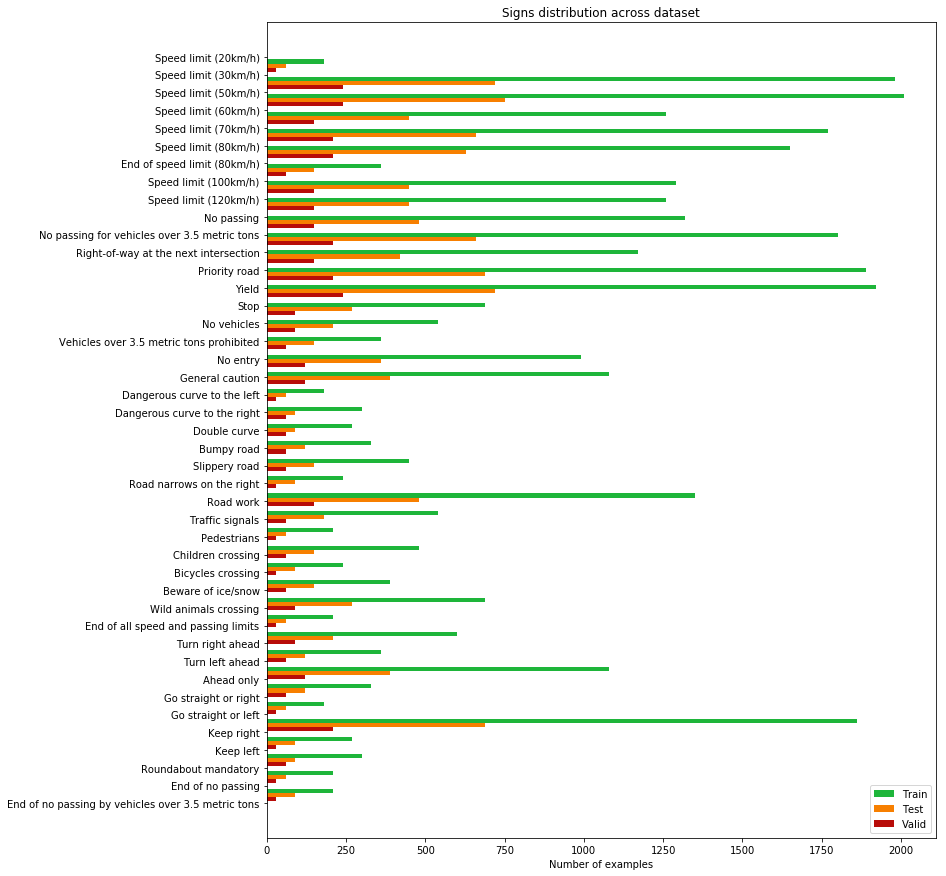

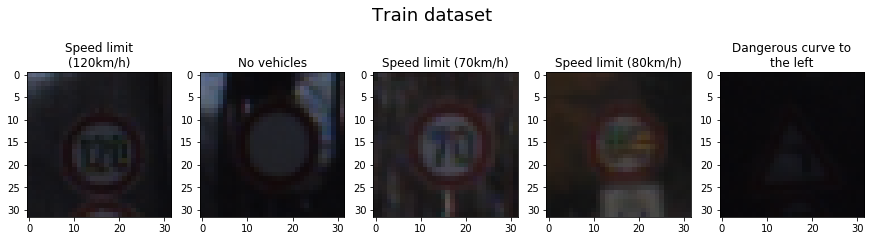

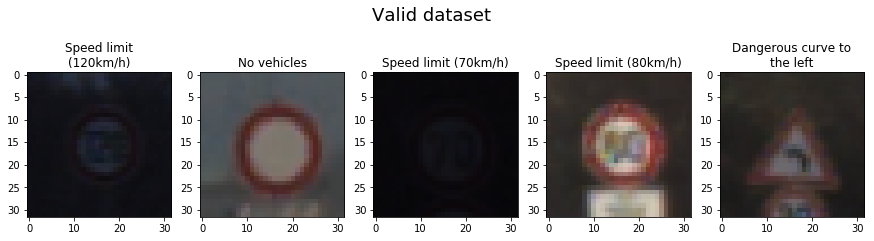

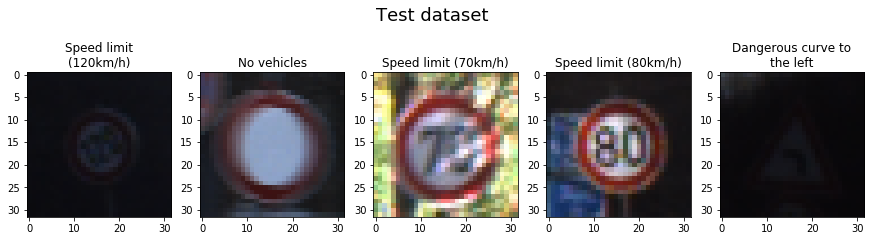

In [47]:
input_data = load_data()
show_data_info(input_data)
visualize_data(input_data)
preprocessed_data = preprocess_data(input_data)

### 5) Define a model for learning

As a starting point LeNet model architecture have been used. But after experimenting with different values and parameters several changes were made:
- number of epochs was increased to 25
- after second convolution dropout was added
- number of convolution layers' channels was increased
- sigmoid was used instead of "relu" activation function for the last fully connected layers

In [48]:
EPOCHS = 25
BATCH_SIZE = 128
mu = 0
sigma = 0.1
features_total = preprocessed_data['labels_number']

def model(x):
    padding_conv = 'VALID'
    padding_pool = 'SAME'

    strides = {
        'conv_1': [1, 1, 1, 1],
        'conv_2': [1, 1, 1, 1],
        'pool_1': [1, 2, 2, 1],
        'pool_2': [1, 2, 2, 1]
    }

    weights = {
        'conv_1': tf.Variable(tf.truncated_normal([5, 5, 1, 16], mean=mu, stddev=sigma)),
        'conv_2': tf.Variable(tf.truncated_normal([5, 5, 16, 32], mean=mu, stddev=sigma)),
        'ful_1': tf.Variable(tf.truncated_normal([800, 300], mean=mu, stddev=sigma)),
        'ful_2': tf.Variable(tf.truncated_normal([300, 70], mean=mu, stddev=sigma)),
        'ful_3': tf.Variable(tf.truncated_normal([70, features_total], mean=mu, stddev=sigma)),
    }

    biases = {
        'conv_bias_1': tf.Variable(tf.zeros(16)),
        'conv_bias_2': tf.Variable(tf.zeros(32)),
        'ful_bias_1': tf.Variable(tf.zeros(300)),
        'ful_bias_2': tf.Variable(tf.zeros(70)),
        'ful_bias_3': tf.Variable(tf.zeros(features_total)),
    }

    kernels = {
        'pool_1': [1, 2, 2, 1],
        'pool_2': [1, 2, 2, 1]
    }

    conv_1 = tf.nn.conv2d(x, weights['conv_1'], strides['conv_1'], padding_conv)
    conv_1 = tf.nn.bias_add(conv_1, biases['conv_bias_1'])
    activation_1 = tf.nn.relu(conv_1)
    pool_1 = tf.nn.max_pool(activation_1, kernels['pool_1'], strides['pool_1'], padding_pool)
    layer_1 = pool_1

    conv_2 = tf.nn.conv2d(layer_1, weights['conv_2'], strides['conv_2'], padding_conv)
    conv_2 = tf.nn.bias_add(conv_2, biases['conv_bias_2'])
    activation_2 = tf.nn.relu(conv_2)
    pool_2 = tf.nn.max_pool(activation_2, kernels['pool_2'], strides['pool_2'], padding_pool)
    layer_2 = pool_2
    layer_2 = tf.nn.dropout(layer_2, 0.75)

    flattened = tf.contrib.layers.flatten(layer_2)

    layer_3 = tf.matmul(flattened, weights['ful_1'])
    layer_3 = tf.nn.bias_add(layer_3, biases['ful_bias_1'])
    layer_3 = tf.nn.relu(layer_3)

    layer_4 = tf.matmul(layer_3, weights['ful_2'])
    layer_4 = tf.nn.bias_add(layer_4, biases['ful_bias_2'])
    layer_4 = tf.nn.sigmoid(layer_4)

    layer_5 = tf.matmul(layer_4, weights['ful_3'])
    layer_5 = tf.nn.bias_add(layer_5, biases['ful_bias_3'])

    logits = layer_5

    return logits

### Step 4. Train and validate the model

As well as for LeNet's model training AdamOptimizer is used, but I've added decaying learning rate - it allows to make learning process smoother especially when the validation accuracy is coming closer to the target value. 

In [49]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, features_total)

rate = 0.001
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.001, global_step, 800, 0.8, staircase=True)

logits = model(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation, global_step=global_step)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(x_data, y_data):
    num_examples = len(x_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = x_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(preprocessed_data['x_train'])

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(preprocessed_data['x_train'], preprocessed_data['y_train'])
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy = evaluate(preprocessed_data['x_valid'], preprocessed_data['y_valid'])

        print("EPOCH {} ...".format(i+1))
        print('Learning rate = {}'.format(sess.run(learning_rate)))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './lenet')
    print("Model saved")

    
    final_accuracy = evaluate(preprocessed_data['x_test'], preprocessed_data['y_test'])
    print("TEST SET ACCURACY = {:.3f}".format(final_accuracy))

Training...

EPOCH 1 ...
Learning rate = 0.0010000000474974513
Validation Accuracy = 0.759

EPOCH 2 ...
Learning rate = 0.0010000000474974513
Validation Accuracy = 0.895

EPOCH 3 ...
Learning rate = 0.000800000037997961
Validation Accuracy = 0.910

EPOCH 4 ...
Learning rate = 0.000800000037997961
Validation Accuracy = 0.926

EPOCH 5 ...
Learning rate = 0.0006400001002475619
Validation Accuracy = 0.935

EPOCH 6 ...
Learning rate = 0.0006400001002475619
Validation Accuracy = 0.940

EPOCH 7 ...
Learning rate = 0.0006400001002475619
Validation Accuracy = 0.942

EPOCH 8 ...
Learning rate = 0.0005120000569149852
Validation Accuracy = 0.941

EPOCH 9 ...
Learning rate = 0.0005120000569149852
Validation Accuracy = 0.944

EPOCH 10 ...
Learning rate = 0.00040960003389045596
Validation Accuracy = 0.943

EPOCH 11 ...
Learning rate = 0.00040960003389045596
Validation Accuracy = 0.941

EPOCH 12 ...
Learning rate = 0.00032768002711236477
Validation Accuracy = 0.950

EPOCH 13 ...
Learning rate = 0.0003

---
## Step 5: Test a Model on New Images
#### 1) Provide a logic for downloading saved  and visualiztion of images

In order to test a model 5 images has been downloaded. All of the images were taken as a screenshots from this video:

https://www.youtube.com/watch?v=r4I_4aP2Xd0

The only preprocessing measure that was taken is cropping the image so that it has a square shape. All the rest (converting to 32x32x1, grayscale and so on) is performed in the code.


In [ ]:
def load_images():
    images_folder = './new_images'
    images = np.array([
        '1.png', # Speed limit (60km/h)
        '2.png', # Yield
        '3.png', # Go straight or right
        '4.png', # No entry
        '5.png' # Priority road
    ])
    labels = np.array([
        3, # Speed limit (60km/h)
        13, # Yield
        36, # Go straight or right
        17, # No entry
        12 # Priority road
    ])
    
    load_image = lambda img_name: cv.imread('{folder}/{file}'.format(folder=images_folder, file=img_name))
    convert_to_rgb = lambda img: cv.cvtColor(img, cv.COLOR_BGR2RGB)
    resize = lambda img: cv.resize(img, (32, 32))
    
    converted_images = list(map(compose(resize, convert_to_rgb, load_image), images))
    
    new_data = {}
    new_data['x_new'] = np.array(converted_images)
    new_data['y_new'] = labels
    new_data['labels'] = input_data['labels']
    new_data['labels_number'] = input_data['labels_number']

    return new_data

def get_sign_name(sign_id, labels):
    get_sign = lambda acc, item: (item[1] if int(item[0]) == sign_id else None) if acc is None else acc
    name = functools.reduce(get_sign, labels, None)
    return name

def show_images(new_data):
    plt.figure(figsize=(15,5))
    for i in range(len(new_data['x_new'])):
        image = new_data['x_new'][i]
        sign_id = new_data['y_new'][i]
        get_sign = lambda acc, item: (item[1] if int(item[0]) == sign_id else None) if acc is None else acc
        title = get_sign_name(sign_id, new_data['labels'])
        plt.subplot(1, 5, i+1)
        plt.title(title)
        plt.imshow(image)
    plt.show()

#### 2) Load images and display them with labels

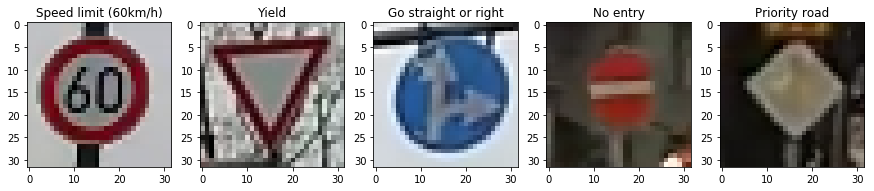

In [84]:
new_data = load_images()
show_images(new_data)

#### 3) Preprocess data and evaluate the model
Here we also define variables for accuracy and predictions that are made by the model. We'll use them later.

In [59]:
preprocessed_new_data = preprocess_data(new_data)

predictions = tf.nn.top_k(tf.nn.softmax(logits), k=5)
new_accuracy = None
new_predictions = None

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    new_accuracy = evaluate(
        preprocessed_new_data['x_new'],
        preprocessed_new_data ['y_new']
    )
    new_predictions = sess.run(predictions, feed_dict={
        x: preprocessed_new_data['x_new'],
        y: preprocessed_new_data ['y_new']
    }) 

INFO:tensorflow:Restoring parameters from ./lenet


## Step 6. Visualizing the result of prediction
Here we display the most probable predictions as the bar chart. Log scale is used because the difference between the major result and all the other ones is huge


Predictions accuracy (for images from the web): 1.0


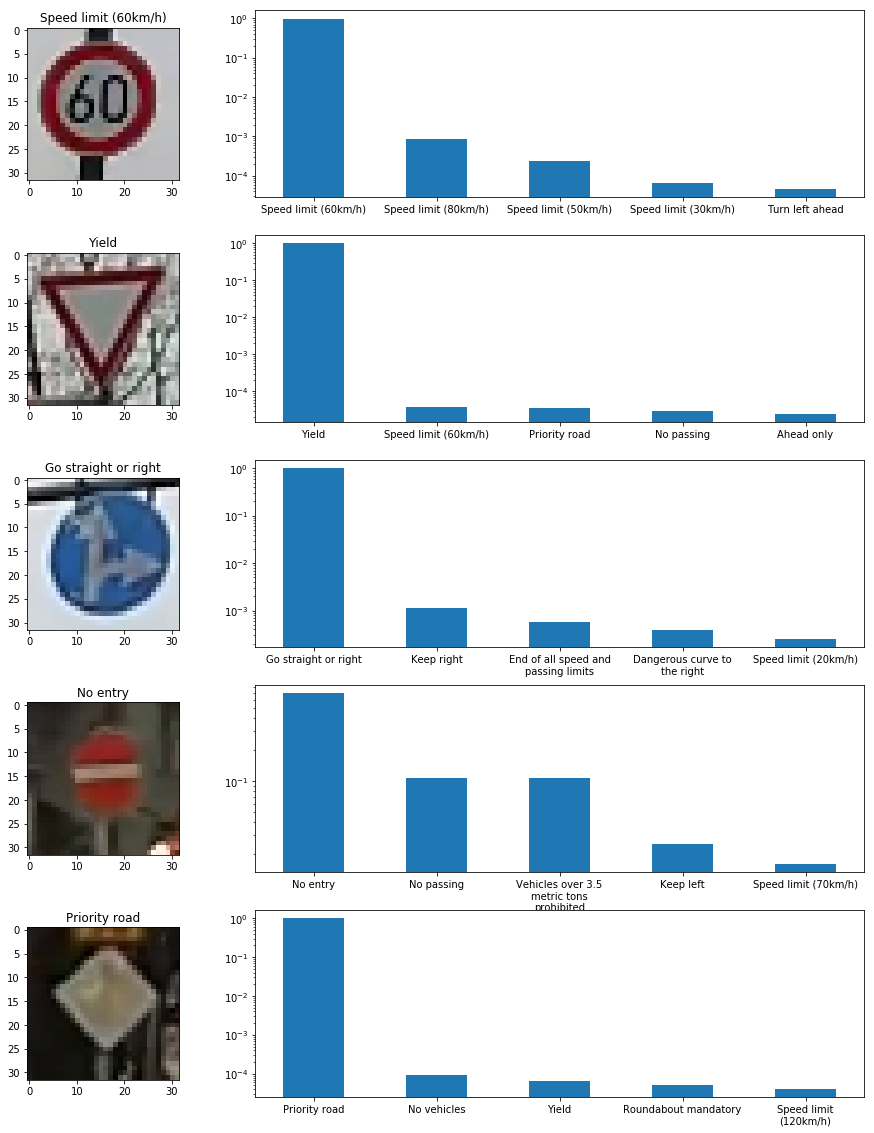

In [92]:
def show_predictions(data, predictions, accuracy):
    images_total = len(data['x_new'])
    
    print('\nPredictions accuracy (for images from the web): {}'.format(accuracy))

    plt.figure(figsize=(15, 4 * images_total))
    grid = gridspec.GridSpec(images_total, 2, width_ratios=[1, 4])
    
    for i in range(images_total):
        image = data['x_new'][i]
        sign_id = data['y_new'][i]
        title = get_sign_name(sign_id, data['labels'])
        
        plt.subplot(grid[2 * i])
        plt.title(title)
        plt.imshow(image)
        
        plt.subplot(grid[2 * i + 1])
        x = np.arange(5)
        plt.bar(x, predictions[0][i], log=True, width=0.5)
        labels = []
        for prediction in predictions[1][i]:
            label = get_sign_name(prediction, data['labels'])
            label = ('\n'.join(wrap(label, 20)))
            labels.append(label)
        plt.xticks(x, labels)
        
    plt.show()
    
show_predictions(new_data, new_predictions, new_accuracy)